# Tensors, Graphs and Sessions

In [1]:
import tensorflow as tf
%matplotlib inline
tf.__version__

'1.13.1'

In [2]:
import numpy as np

### Some noisy data for linear regression

In [3]:
npx=np.random.uniform(1, 10, 100)
npyl = 2 * npx - 5 + 3.0*np.random.normal(size=100) 

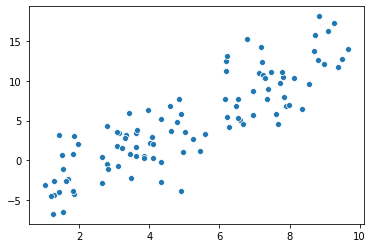

In [4]:
import seaborn as sns
sns.scatterplot(x=npx, y=npyl);

---
We're using an interactive session here.

In [5]:
# Always give me a brand-new session and graph
try:
    sess.close()
except:
    pass
tf.reset_default_graph()
graph = tf.get_default_graph()
sess = tf.InteractiveSession()

In [6]:
npx = np.transpose([npx])
npyl = np.transpose([npyl])
npx.shape, npyl.shape

((100, 1), (100, 1))

#### Placeholders for input data

In [7]:
x = tf.placeholder(shape=(None,1), dtype=tf.float32)
lbls = tf.placeholder(shape=(None,1), dtype=tf.float32)
x.shape, lbls.shape

(TensorShape([Dimension(None), Dimension(1)]),
 TensorShape([Dimension(None), Dimension(1)]))

In [8]:
with tf.variable_scope('affine'):
    a = tf.Variable([[.5]], name="weights", dtype=tf.float32)
    b = tf.Variable([[0.]], name="bias", dtype=tf.float32)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
a,b

(<tf.Variable 'affine/weights:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'affine/bias:0' shape=(1, 1) dtype=float32_ref>)

This is the *hypothesis*, namely: *We believe the behaviour may be linear with some offset*

In [10]:
y = tf.matmul(x, a) + b

In [11]:
init = tf.global_variables_initializer()

We can see that the graph has been silently collecting all the variables that we created:

In [12]:
graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'affine/weights:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'affine/bias:0' shape=(1, 1) dtype=float32_ref>]

In [13]:
sess.run(init)
sess.run(y, feed_dict={x: npx, lbls: npyl})[:5]

array([[3.8057876],
       [4.271236 ],
       [1.329087 ],
       [3.9018347],
       [1.8094888]], dtype=float32)

In [14]:
loss = tf.math.reduce_mean((y - lbls)**2)
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [15]:
gradients = tf.gradients(loss, [a, b])
gradients

[<tf.Tensor 'gradients/MatMul_grad/MatMul_1:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'gradients/add_grad/Reshape_1:0' shape=(1, 1) dtype=float32>]

---
Optimization step with loss function $L$ and learning rate $\lambda$
$$
a_{t+1} = a_t - \nabla_a L * \lambda
$$

In [16]:
learning_rate = 1e-2
update_a = tf.assign_sub(a, learning_rate * gradients[0])
update_b = tf.assign_sub(b, learning_rate * gradients[1])

In [17]:
for i in range(2000):
    sess.run([loss, update_a, update_b], feed_dict={x: npx, lbls: npyl})
l, aa, bb = sess.run([loss, update_a, update_b], feed_dict={x: npx, lbls: npyl})
l, aa, bb

(8.678056,
 array([[1.9997845]], dtype=float32),
 array([[-5.3746114]], dtype=float32))

```aa``` and ```bb``` are the regression coefficients that our ordinary least squared algorithm has found. Note that these match well with the coefficients that we have used to generate the data.

In [18]:
xreg = np.linspace(0,10, 2)
yreg = np.squeeze(aa * xreg + bb)

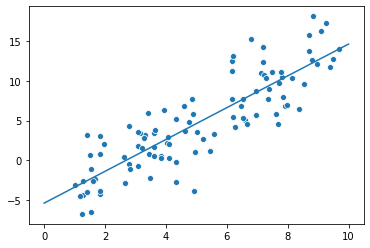

In [19]:
sns.scatterplot(x=np.squeeze(npx), y=np.squeeze(npyl));
sns.lineplot(x=xreg, y=yreg);

That's a lot of code for a linear regression. In practice you would use a provided library like ```statsmodel``` or any of the ```scipy``` variants. Tensorflow Tensors are very low-level tools. We'll wanted to demonstrate the usage of the API and the fact that your code builds computational graphs that are executed in the context of a session. The execution could as well be delegated to a cluster of GPU-powered servers, without you even noticing. That's the advantage of graph-based computing. You can test one and the same code on small data on your local machine and after verifying that everything works deploy it into an appropriately sized infrastructure to deal with the full dataset. 